In [1]:
from codvidutils.utils import load_pictures, adding_images
from codvidutils.imageproc import map_categorical
import numpy as np
import pandas as pd
num_channels= 3
test_class = pd.read_csv('data/test_split_v5.csv', sep=' ')#, header=True)#, names=['patientID', 'image_path', 'class'])
X_test = load_pictures(test_class,"data/test/",channels = num_channels)

values_dict = {'COVID-19': 1,'pneumonia': 2,'normal': 0}
test_class['class_categorical'] = test_class['class'].apply(map_categorical, args=(values_dict,))
diseaseID_test  = np.asarray(test_class["class_categorical"])
original_test = len(diseaseID_test)
print('shape X: {},  disease_ID (Y): {}'.format(X_test.shape[0],  diseaseID_test.shape[0] ))


shape X: 1525,  disease_ID (Y): 1525


In [2]:
X_test, diseaseID_test = adding_images(X_test, diseaseID_test, strides=5 )
X_test = X_test / 255 
print('shape X: {},  disease_ID (Y): {}'.format(X_test.shape[0],  diseaseID_test.shape[0] ))
Y_test = np.copy(diseaseID_test)
Y_test[Y_test==2]=0

shape X: 3000,  disease_ID (Y): 3000


In [151]:
val_class = pd.read_csv('data/validation_set.csv', sep=' ')#, header=True)#, names=['patientID', 'image_path', 'class'])
X_val = load_pictures(val_class,"data/test/",channels = num_channels)

val_class['class_categorical'] = val_class['class'].apply(map_categorical, args=(values_dict,))
diseaseID_val  = np.asarray(val_class["class_categorical"])
X_val = X_val[:,10:190,10:190,:]
X_val = X_val / 255

Y_val = np.copy(diseaseID_val)
Y_val[Y_val==2]=0

In [152]:
from tensorflow.keras.models import load_model
import tensorflow.keras

model = load_model("Inc2uncALL_ADD.hdf5")
p_val = model.predict(X_val)

In [ ]:
probs += [model.predict(X_test)]
probs += [model.predict(X_test)]

In [ ]:
probs = np.array(probs)
probs = np.reshape(probs,[14,3000])
probs.shape

In [ ]:
p_val.shape
np.savetxt("Inc2uncALL_ADD_val60.txt", p_val)
np.savetxt("Inc2uncALL_ADD_14test.txt", probs)

In [39]:
#del X_test, X_val
"""
Restart the kernel and don't run the cells with the model.

"""
probs = np.loadtxt("Inc2uncALL_ADD_14test.txt")
p_val = np.loadtxt("Inc2uncALL_ADD_val60.txt")

In [40]:
predictive_mean = np.mean(probs, axis=0)
predictive_variance = np.var(probs, axis=0)
print(predictive_mean.shape)

(3000,)


In [154]:
from sklearn.metrics import mean_squared_error
e_2 = mean_squared_error(Y_val, p_val)
print(np.sqrt(e_2))

0.29879861695650384


In [155]:
Mean = predictive_mean 
Unce  = np.sqrt(predictive_variance+e_2)
print("******* MEAN values ******")
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize

cm = confusion_matrix(Y_test, Mean.round())
cm_norm = normalize(cm, norm = 'l1')
print(cm, "\n", cm_norm)
print("******* ORIGINAL images ******")
cm = confusion_matrix(Y_test[:original_test], Mean[:original_test].round())
cm_norm = normalize(cm, norm = 'l1')
print(cm, "\n", cm_norm)

print("******* ADDED images ******")
cm = confusion_matrix(Y_test[original_test:], Mean[original_test:].round())
cm_norm = normalize(cm, norm = 'l1')
print(cm, "\n", cm_norm)

******* MEAN values ******
[[1363  103]
 [ 513 1021]] 
 [[0.92974079 0.07025921]
 [0.33441982 0.66558018]]
******* ORIGINAL images ******
[[1363  103]
 [  23   36]] 
 [[0.92974079 0.07025921]
 [0.38983051 0.61016949]]
******* ADDED images ******
[[  0   0]
 [490 985]] 
 [[0.         0.        ]
 [0.33220339 0.66779661]]


In [156]:
cm = confusion_matrix(Y_test, Mean.round())
cm_norm = normalize(cm, norm = 'l1')
print(cm, "\n", cm_norm)
print("Mean")
cm = confusion_matrix(Y_test, Mean.round())
print(cm)

print("Mean+ Unc")
cm = confusion_matrix(Y_test, (Mean+Unce).round())
print(cm)

print("Mean- Unc")
cm = confusion_matrix(Y_test, (Mean-Unce).round())
print(cm)

[[1363  103]
 [ 513 1021]] 
 [[0.92974079 0.07025921]
 [0.33441982 0.66558018]]
Mean
[[1363  103]
 [ 513 1021]]
Mean+ Unc
[[1143  323]
 [ 185 1349]]
Mean- Unc
[[1452   14]
 [ 917  617]]


In [157]:
print(" Example values")
print("Normal people")
for p, u in zip(Mean[diseaseID_test==0][:5],Unce[diseaseID_test==0][:5]):
    print(p, "+/- ", u)
print("Neumonia")
for p, u in zip(Mean[diseaseID_test==2][:5],Unce[diseaseID_test==2][:5]):
    print(p, "+/- ", u)
print("COVID-19")
for p, u in zip(Mean[diseaseID_test==1][:5],Unce[diseaseID_test==1][:5]):
    print(p, "+/- ", u)

 Example values
Normal people
0.152753939053842 +/-  0.30594372636440986
0.048027815496815104 +/-  0.30033311239915433
0.4392763280442783 +/-  0.3383066926704469
0.29251833925289766 +/-  0.38512955021501216
0.053211220274014134 +/-  0.3058984761058702
Neumonia
0.02103836026591515 +/-  0.301140511150355
0.01544683900803128 +/-  0.29916771265359005
0.4294019990733692 +/-  0.36245183000085296
0.12292819483471769 +/-  0.31946358165229455
0.009968219374838685 +/-  0.2989416719321246
COVID-19
0.016736002480164252 +/-  0.3000017438126504
0.0026337588420314467 +/-  0.29882744332297295
0.9132723978587559 +/-  0.3103357049060016
0.7341468312910625 +/-  0.38714295493592754
0.9866890779563359 +/-  0.2991814332574714


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

testScoreECM = 0
testScoreEAM = 0

for pred in probs:
    testScoreECM += mean_squared_error(Y_test, pred)
    testScoreEAM += mean_absolute_error(Y_test, pred)

testScoreECM = testScoreECM/len(probs)
testScoreEAM = testScoreEAM/len(probs)

varECM = 0
varEAM = 0

for pred in probs:
    varECM += (mean_squared_error(Y_test, pred)-testScoreECM)**2
    varEAM += (mean_absolute_error(Y_test, pred)-testScoreEAM)**2

varECM = (varECM/len(probs))**(0.5)
varEAM = (varEAM/len(probs))**(0.5)

print('Mean ECM: %.4f' % (testScoreECM))
print('Mean EAM: %.4f' % (testScoreEAM))
print('variance ECM: %.4f' % (varECM))
print('variance EAM: %.4f' % (varEAM))

In [132]:
def get_counts(Pred, Upre, true_Y,nbins, label):
    import numpy as np
    mean = Pred[true_Y == label]
    unce = Upre[true_Y == label]
    bins = np.linspace(0,1,nbins+1)
    probability = np.zeros([mean.shape[0], nbins])
    print(probability.shape)

    for i in range(mean.shape[0]):
        for j in range(nbins):
            probability[i,j] = (norm.cdf(bins[j+1],loc=mean[i],scale=unce[i])-norm.cdf(bins[j],loc=mean[i],scale=unce[i]))
    
    counts = np.sum(probability,axis = 0)
    variance = np.multiply(probability,(1- probability))
    variance = np.sum(variance,axis=0)
    uncounts = np.sqrt(variance)
    return counts, uncounts

In [133]:
def get_counts_by_class(Pred,Upre, true_Y, nbins):
    import numpy as np
    dic_counts = {0: [], 1:[],2:[] }
    dic_uncounts = {0: [], 1:[],2:[] }
    for label in np.unique(true_Y):
        print(label)
        dic_counts[label], dic_uncounts[label] = get_counts(Pred,Upre,true_Y,nbins, label)

    bins = np.linspace(0,1,nbins+1)
    bins += (bins[5]-bins[4])/2
    return dic_counts, dic_uncounts, bins[:-1]

In [158]:
dic_counts_3, dic_variance_3, bins = get_counts_by_class(Mean,Unce, diseaseID_test, nbins=60)
dic_counts_2, dic_variance_2, nbins = get_counts_by_class(Mean,Unce, Y_test, nbins=20)

0.0
(880, 60)
1.0
(1534, 60)
2.0
(586, 60)
0.0
(1466, 20)
1.0
(1534, 20)


In [167]:
np.sum(dic_counts_3[1])

1014.5041468011048

In [107]:
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 'large'
mpl.rcParams['ytick.labelsize'] = 'large'
mpl.rcParams['axes.labelsize'] = 'large'
#mpl.rcParams['xtick.labelsize'] = 'XX-large'
#mpl.rcParams['ytick.labelsize'] = 'XX-large'
#mpl.rcParams['axes.labelsize'] = 'XX-large'
mpl.rcParams['axes.titlesize'] = 'large'
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['font.size'] = '16'

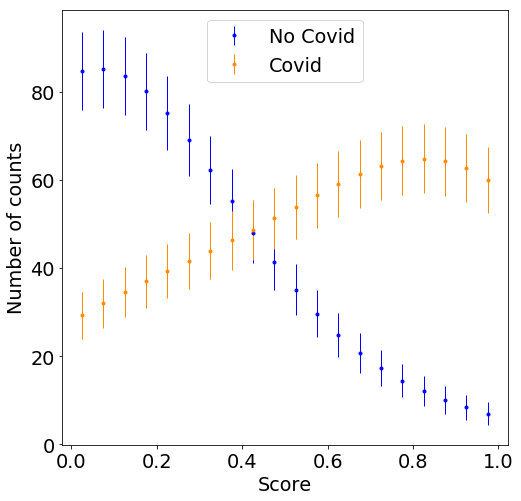

In [159]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))# 6,6

plt.style.use('seaborn-deep')
plt.errorbar(nbins, dic_counts_2[0] ,fmt=" ",marker='.', yerr=dic_variance_2[0],lw=1, color="blue",label ="No Covid")
plt.errorbar(nbins, dic_counts_2[1] ,fmt=" ",marker='.', yerr=dic_variance_2[1],lw=1, color="darkorange",label ="Covid")
plt.ylabel('Number of counts')
plt.xlabel('Score')
plt.legend(loc="upper center")
#plt.savefig(filename)

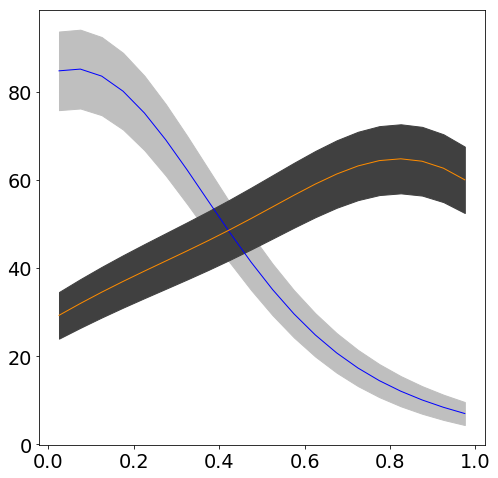

In [162]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))# 6,6

plt.style.use('seaborn-deep')
plt.plot(nbins, dic_counts_2[0],lw=1, color="blue",label ="Normal")
plt.fill_between(nbins, dic_counts_2[0]-dic_variance_2[0], dic_counts_2[0]+dic_variance_2[0],color='0.75')
#plt.errorbar(bins, dic_counts_2[0] ,fmt=" ",marker='.', yerr=dic_variance_2[0],lw=1, color="darkorange",label ="Covid")
#plt.errorbar(bins, dic_counts_3[2] ,fmt=" ",marker='.', yerr=dic_variance_3[2],lw=1, color="red",label ="Pneumonia")
plt.plot(nbins, dic_counts_2[1],lw=1, color="darkorange",label ="Covid")
plt.fill_between(nbins, dic_counts_2[1]-dic_variance_2[1], dic_counts_2[1]+dic_variance_2[1],color='0.25')

#plt.savefig(filename)

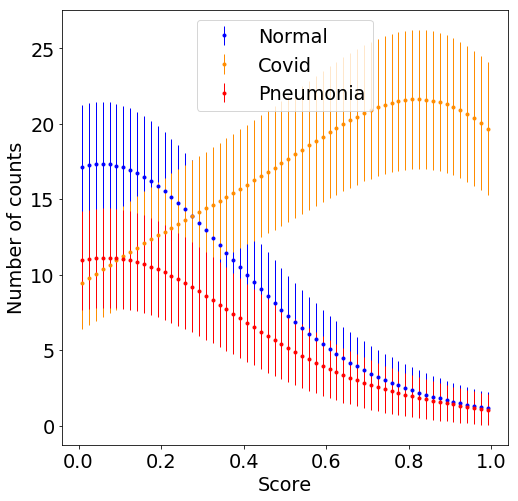

In [165]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))# 6,6

plt.style.use('seaborn-deep')
plt.errorbar(bins, dic_counts_3[0] ,fmt=" ",marker='.', yerr=dic_variance_3[0],lw=1, color="blue",label ="Normal")
plt.errorbar(bins, dic_counts_3[1] ,fmt=" ",marker='.', yerr=dic_variance_3[1],lw=1, color="darkorange",label ="Covid")
plt.errorbar(bins, dic_counts_3[2] ,fmt=" ",marker='.', yerr=dic_variance_3[2],lw=1, color="red",label ="Pneumonia")
#plt.hist(Mean[(diseaseID_test==2)],50,histtype='step',color='blue',lw=2,label= "No covid" )
plt.ylabel('Number of counts')
plt.xlabel('Score')
plt.legend(loc="upper center")
#plt.savefig(filename)

In [50]:
Upper = Mean + Unce
Upper[Upper>1] = 1
Upper[Upper<0] = 0
Lower = Mean - Unce
Lower[Lower>1] = 1
Lower[Lower<0] = 0

In [51]:
fpr, tpr, thresholds = roc_curve(Y_test, Mean)
fpr_U, tpr_U, thr = roc_curve(Y_test,Upper)
fpr_L, tpr_L, thr = roc_curve(Y_test,Lower)
roc_auc = auc(fpr,tpr)
roc_auc_U = auc(fpr_U,tpr_U)
roc_auc_L = auc(fpr_L,tpr_L)
print(roc_auc, roc_auc_L, roc_auc_U)

0.9053366974321029 0.8727110462086299 0.9070100015830355


In [61]:
for f in fpr_L:
    print(f, f in fpr_U)

0.0 True
0.0 True
0.0 True
0.0006821282401091405 False
0.0006821282401091405 False
0.001364256480218281 False
0.001364256480218281 False
0.0020463847203274215 False
0.0020463847203274215 False
0.002728512960436562 False
0.002728512960436562 False
0.0034106412005457027 False
0.0034106412005457027 False
0.004092769440654843 False
0.004092769440654843 False
0.0047748976807639835 True
0.0047748976807639835 True
0.005457025920873124 True
0.005457025920873124 True
0.006139154160982265 True
0.006139154160982265 True
0.0068212824010914054 True
0.0068212824010914054 True
0.007503410641200546 True
0.007503410641200546 True
0.008185538881309686 True
0.008185538881309686 True
0.008867667121418827 True
0.008867667121418827 True
0.009549795361527967 True
0.009549795361527967 True
0.010231923601637109 True
0.010231923601637109 True
0.010914051841746248 True
0.010914051841746248 True
0.011596180081855388 True
0.011596180081855388 True
0.01227830832196453 True
0.01227830832196453 True
0.012960436562073

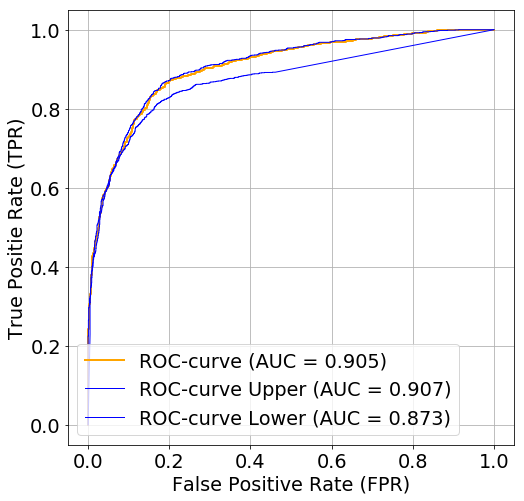

In [52]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8))#,6
plt.style.use('seaborn-deep') 
#plt.title("Simulation", weight="bold", x=0.50)
plt.grid(True)
#yticks(np.arange(0.97, 1, step=0.005))
lw = 2
plt.plot(fpr, tpr, color='orange',lw=2, label='ROC-curve (AUC = %0.3f)' % (roc_auc))
plt.plot(fpr_U, tpr_U, color='blue',lw=1, label='ROC-curve Upper (AUC = %0.3f)' % (roc_auc_U))
plt.plot(fpr_L, tpr_L, color='blue',lw=1, label='ROC-curve Lower (AUC = %0.3f)' % (roc_auc_L))
#plt.fill_between(g[0:nbins], counts_back-(variance_back)**0.5, counts_back+(variance_back)**0.5,color='0.75')


plt.ylabel('True Positie Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')

#plt.title("Simulation Preliminary", color = '#e159e1',loc="left", weight="bold", size="large")
plt.legend(loc="lower left")
plt.show()